In [11]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

mpl.rc('figure', figsize=(8, 5))
mpl.rc('figure', dpi=300)

import warnings
warnings.simplefilter("ignore")

# 신경망 성능 개선

In [12]:
from keras.datasets import mnist
from keras.utils import np_utils

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

신경망의 예측 성능 및 수렴 성능을 개선하기 위해서는 다음과 같은 추가적인 고려를 해야 한다.

* 오차(목적) 함수 개선: cross-entropy cost function
* Activation 함수 선택: hyper-tangent and ReLu
* 가중치 초기값: weight initialization
* 정규화: regularization
* Softmax 출력
* Batch Normalization


## 교차 엔트로피 오차 함수

교차 엔트로피(Cross-Entropy) 형태의 오차 함수를 사용하면 출력 레이어에서 활성화 함수의 도함수에 의한 영향을 제거할 수 있다.

$$
\begin{eqnarray} 
  C = y \log z^{(L)} + (1-y) \log (1-z^{(L)})
\end{eqnarray}
$$

이 경우 출력 레이어의 가중치에 대한 미분값은 다음과 같아진다.

$$
\begin{eqnarray}
\frac{\partial C}{\partial w_j^{(L)}} 
&=& \left(\frac{y }{z^{(L)}} - \frac{(1-y)}{1-z^{(L)}} \right) \frac{\partial z^{(L)}}{\partial w_j^{(L)}} \\
&=& \left(\frac{y}{\sigma(a)} - \frac{(1-y)}{1-\sigma(a)} \right)\sigma'(a) z^{(l-1)}_j \\
&=& \frac{\sigma'(a) }{\sigma(a) (1-\sigma(a))} (\sigma(a)-y) z^{(l-1)}_j  \\
&=& (\sigma(a)-y) z^{(l-1)}_j \\ 
&=& (z^{(L)}-y) z^{(l-1)}_j \\ 
\\
\frac{\partial C}{\partial b^{(L)}} &=&  z^{(L)} - y
\end{eqnarray}
$$

## Keras 에서 교차 엔트로피 사용

Keras에서는 ``compile`` 메서드의 ``loss`` 인수를 설정하여 교차 엔트로피를 포함한 다양한 오차 함수를 사용할 수 있다.
``loss`` 인수에서 설정 가능한 값 중 몇 가지를 예를 들면 다음과 같다.

* ``mean_squared_error``
* ``mean_squared_logarithmic_error``
* ``mean_absolute_error``
* ``mean_absolute_percentage_error``
* ``binary_crossentropy``
* ``categorical_crossentropy``


In [15]:
np.random.seed(0)
model0 = Sequential()
model0.add(Dense(15, input_dim=784, activation="sigmoid"))
model0.add(Dense(10, activation="sigmoid"))
model0.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [16]:
%%time
hist0 = model0.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 51.1 s, sys: 5.52 s, total: 56.7 s
Wall time: 46.4 s


In [32]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [33]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 13s, sys: 8.86 s, total: 1min 22s
Wall time: 1min 2s


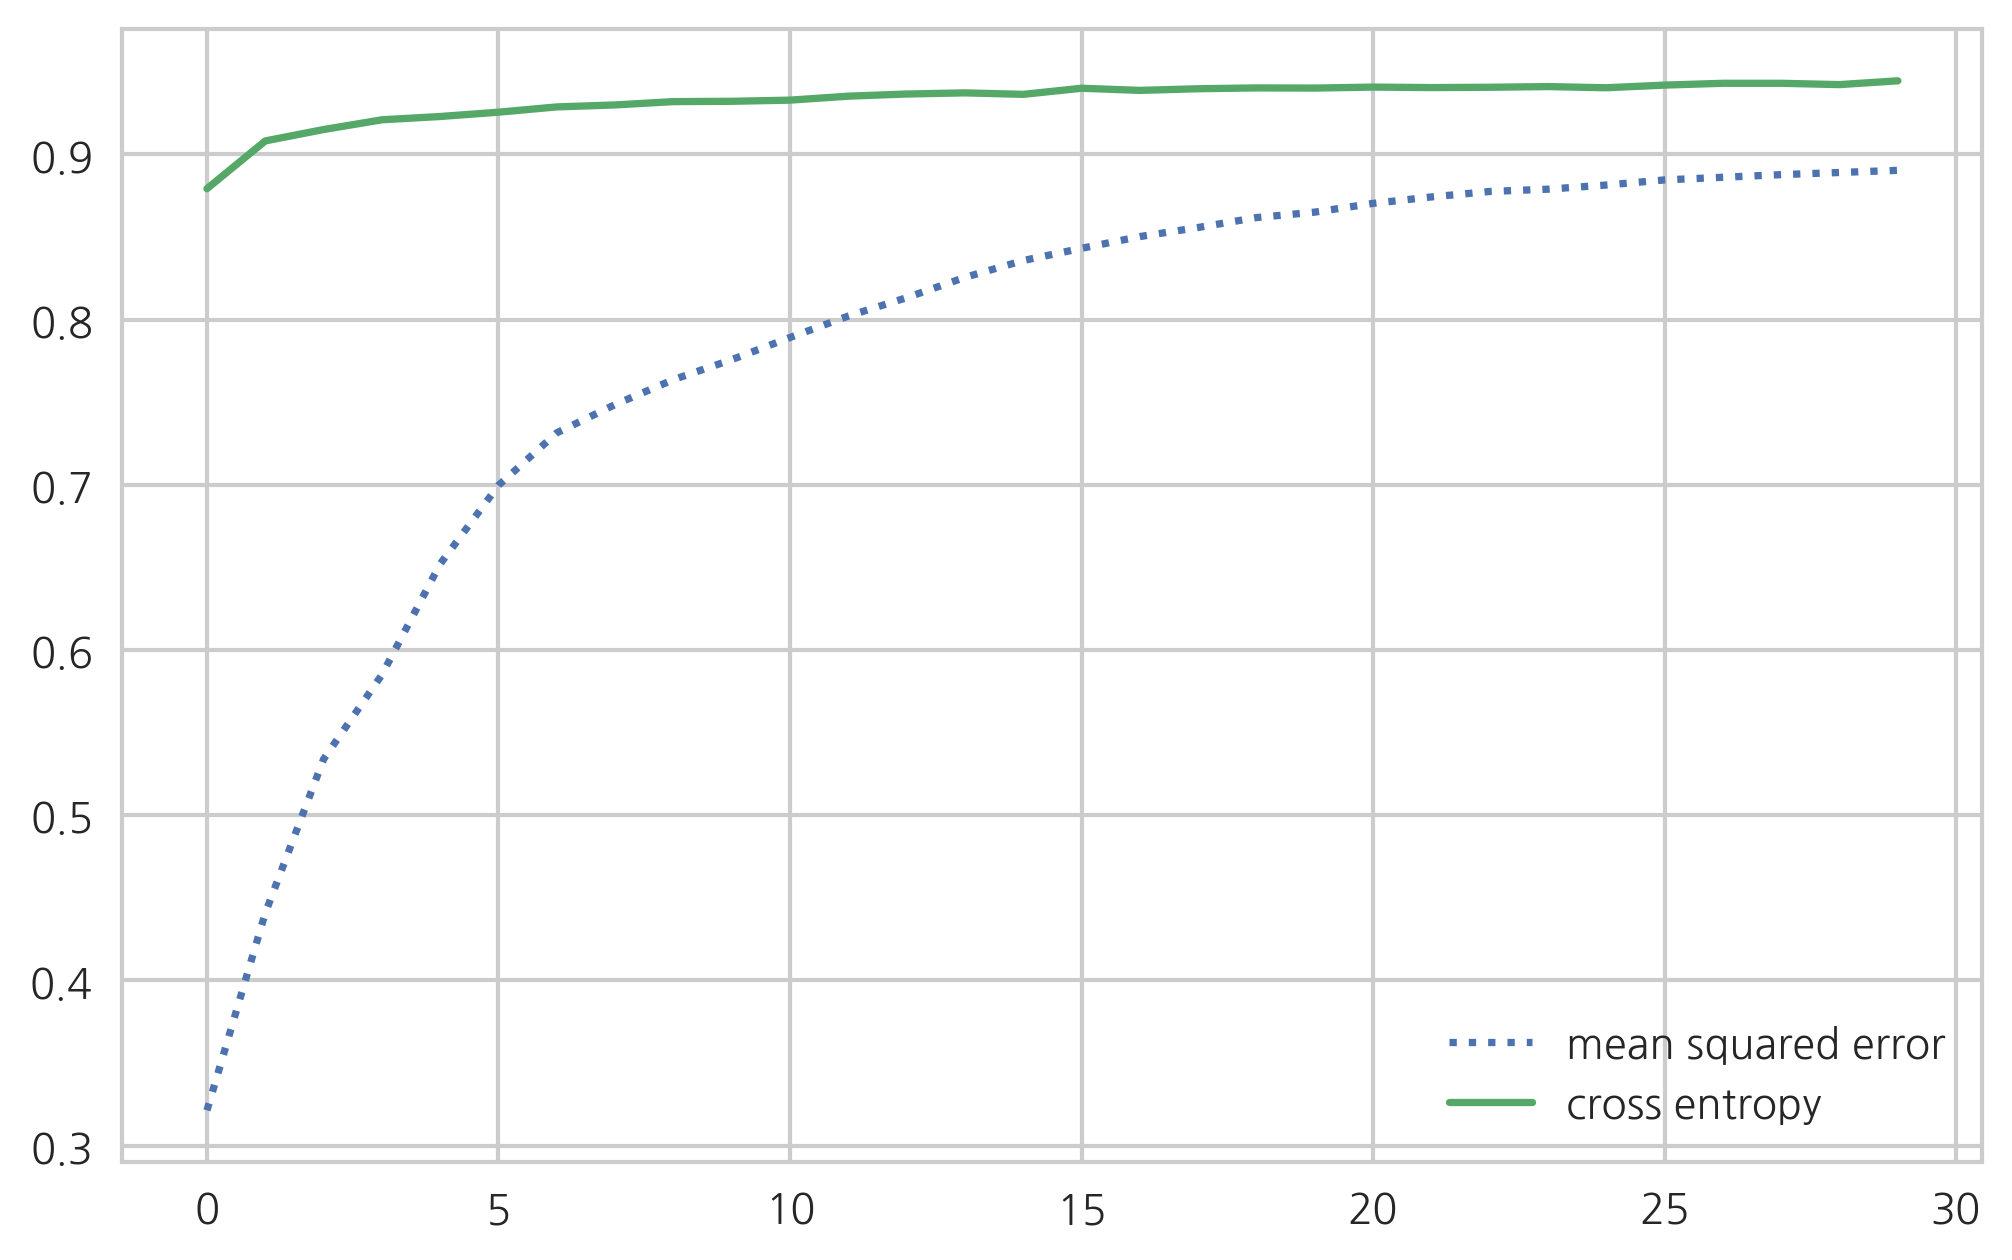

In [11]:
plt.plot(hist0.history['val_acc'], ls=":", label="mean squared error")
plt.plot(hist1.history['val_acc'], label="cross entropy")
plt.legend()
plt.show()

## 하이퍼탄젠트 활성화 함수

활성화 함수로 로지스틱 함수 대신 하이퍼탄젠트(Hypertangent)를 사용하면 도함수의 최댓값이 로지스틱 함수의 4배인 1이 되므로 그레디언트 감소 현상이 줄어든다.

$$
\begin{eqnarray}
  \tanh(a) \equiv \frac{e^a-e^{-a}}{e^a+e^{-a}} = 2\sigma(2a) - 1
\end{eqnarray}
$$

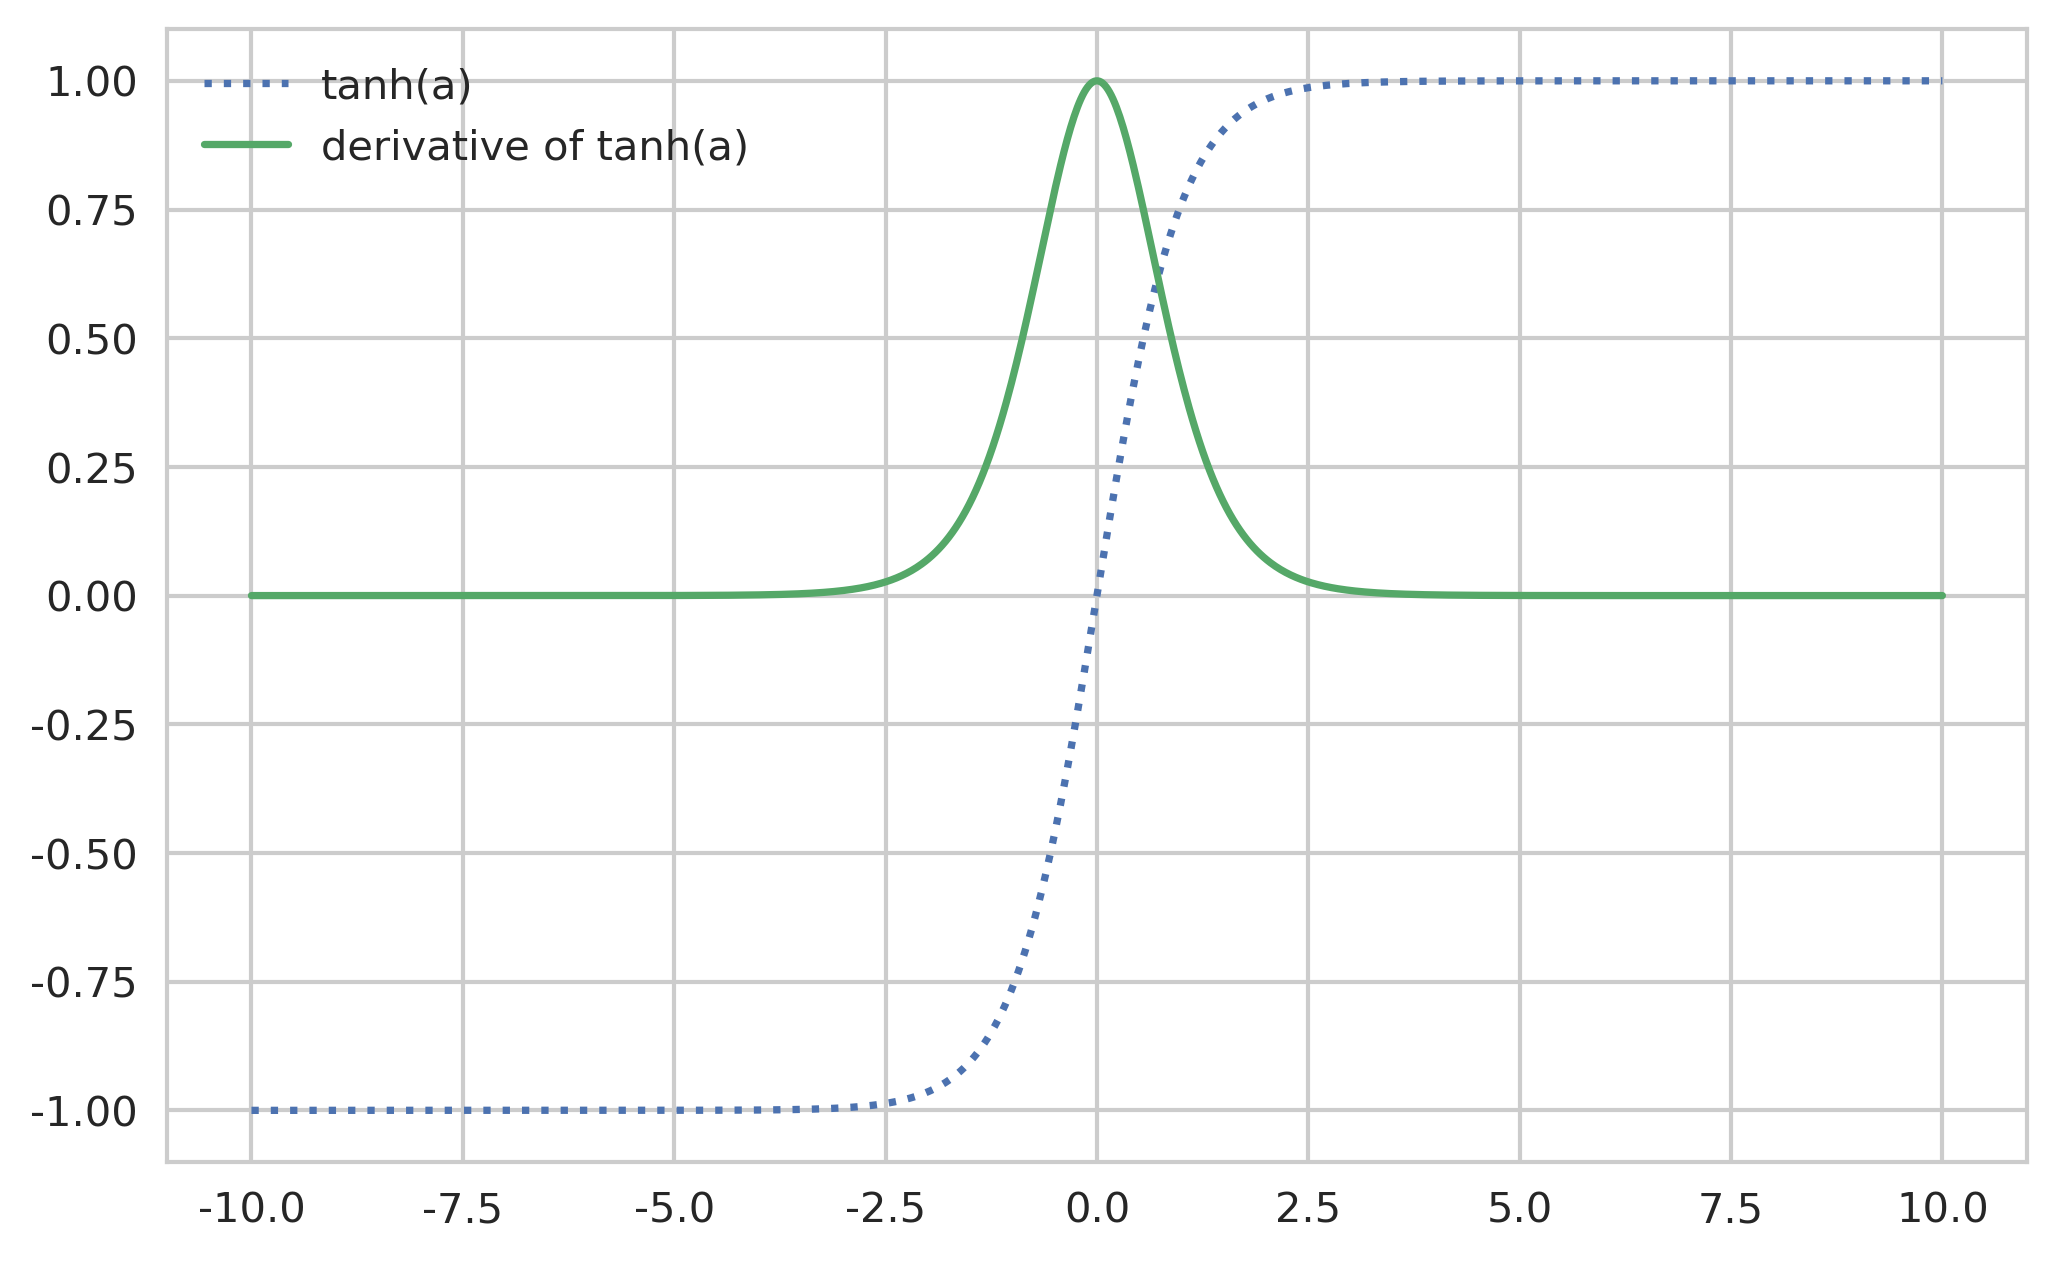

In [25]:
tanh = lambda x: np.tanh(x)
tanh_prime = lambda x: 1 - np.tanh(x) ** 2
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, tanh(xx), 'b:', label="tanh(a)")
plt.plot(xx, tanh_prime(xx), 'g-', label="derivative of tanh(a)")
plt.legend()
plt.show()

## Rectified Linear Unit (ReLu)

가장 좋은 방법은 Rectified Linear Unit (ReLu) 활성화 함수를 사용하는 것이다. ReLu는 가중치총합 $a$가 큰 경우에도 기울기(gradient)가 1로 유지되므로 $a$이 커도 그레디언트 감소 현상이 발생하지 않는다. CNN과 같이 레이어의 수가 많은 경우에 유용하다.

$$
\begin{eqnarray}
  \max(0, a)
\end{eqnarray}
$$

$a$가 음수인 경우에도 기울기가 0이 되지 않도록 하는 Leaky ReLu도 사용한다.

$$
\begin{eqnarray}
  \max(\alpha a, a) \;\; (0 < \alpha < 1)
\end{eqnarray}
$$


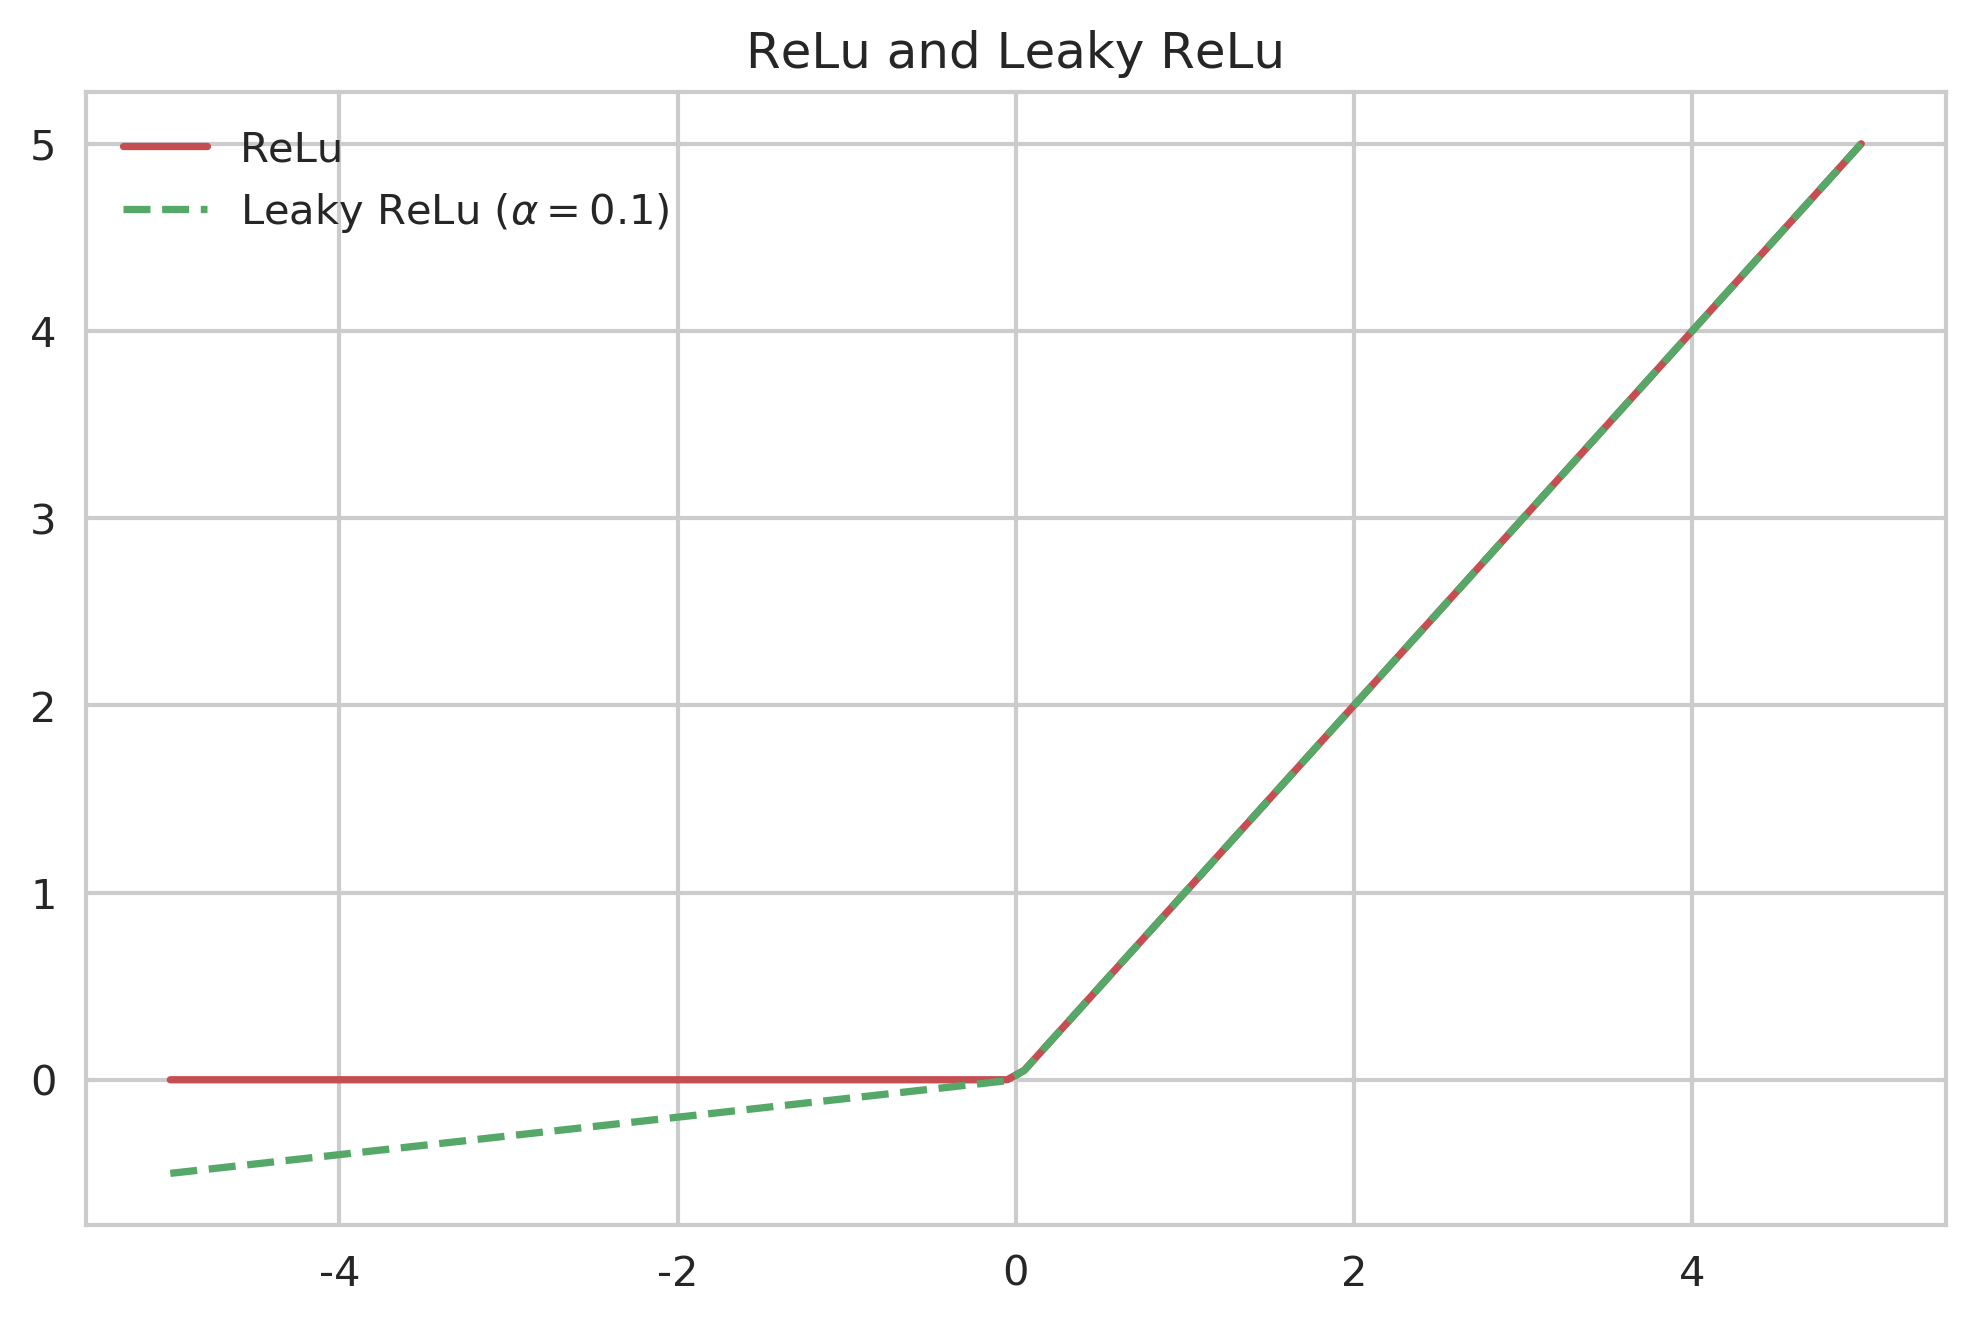

In [10]:
a = np.linspace(-5, 5, 100)
relu = np.maximum(0, a)
leakyrelu = np.maximum(0.1 * a, a)
plt.plot(a, relu, 'r-', label="ReLu")
plt.plot(a, leakyrelu, 'g--', label="Leaky ReLu ($\\alpha=0.1$)")
plt.title("ReLu and Leaky ReLu")
plt.legend()
plt.show()

Keras에서는 Dense 네트워크를 생성할 때 `activation` 인수의 값을 바꿀 수 있다.

* `sigmoid`
* `tanh`
* `relu`

In [26]:
np.random.seed(0)
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="tanh"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [27]:
%%time
hist2 = model2.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 17s, sys: 9.33 s, total: 1min 27s
Wall time: 1min 4s


In [28]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="relu"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [29]:
%%time
hist3 = model3.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 13s, sys: 8.67 s, total: 1min 21s
Wall time: 58.3 s


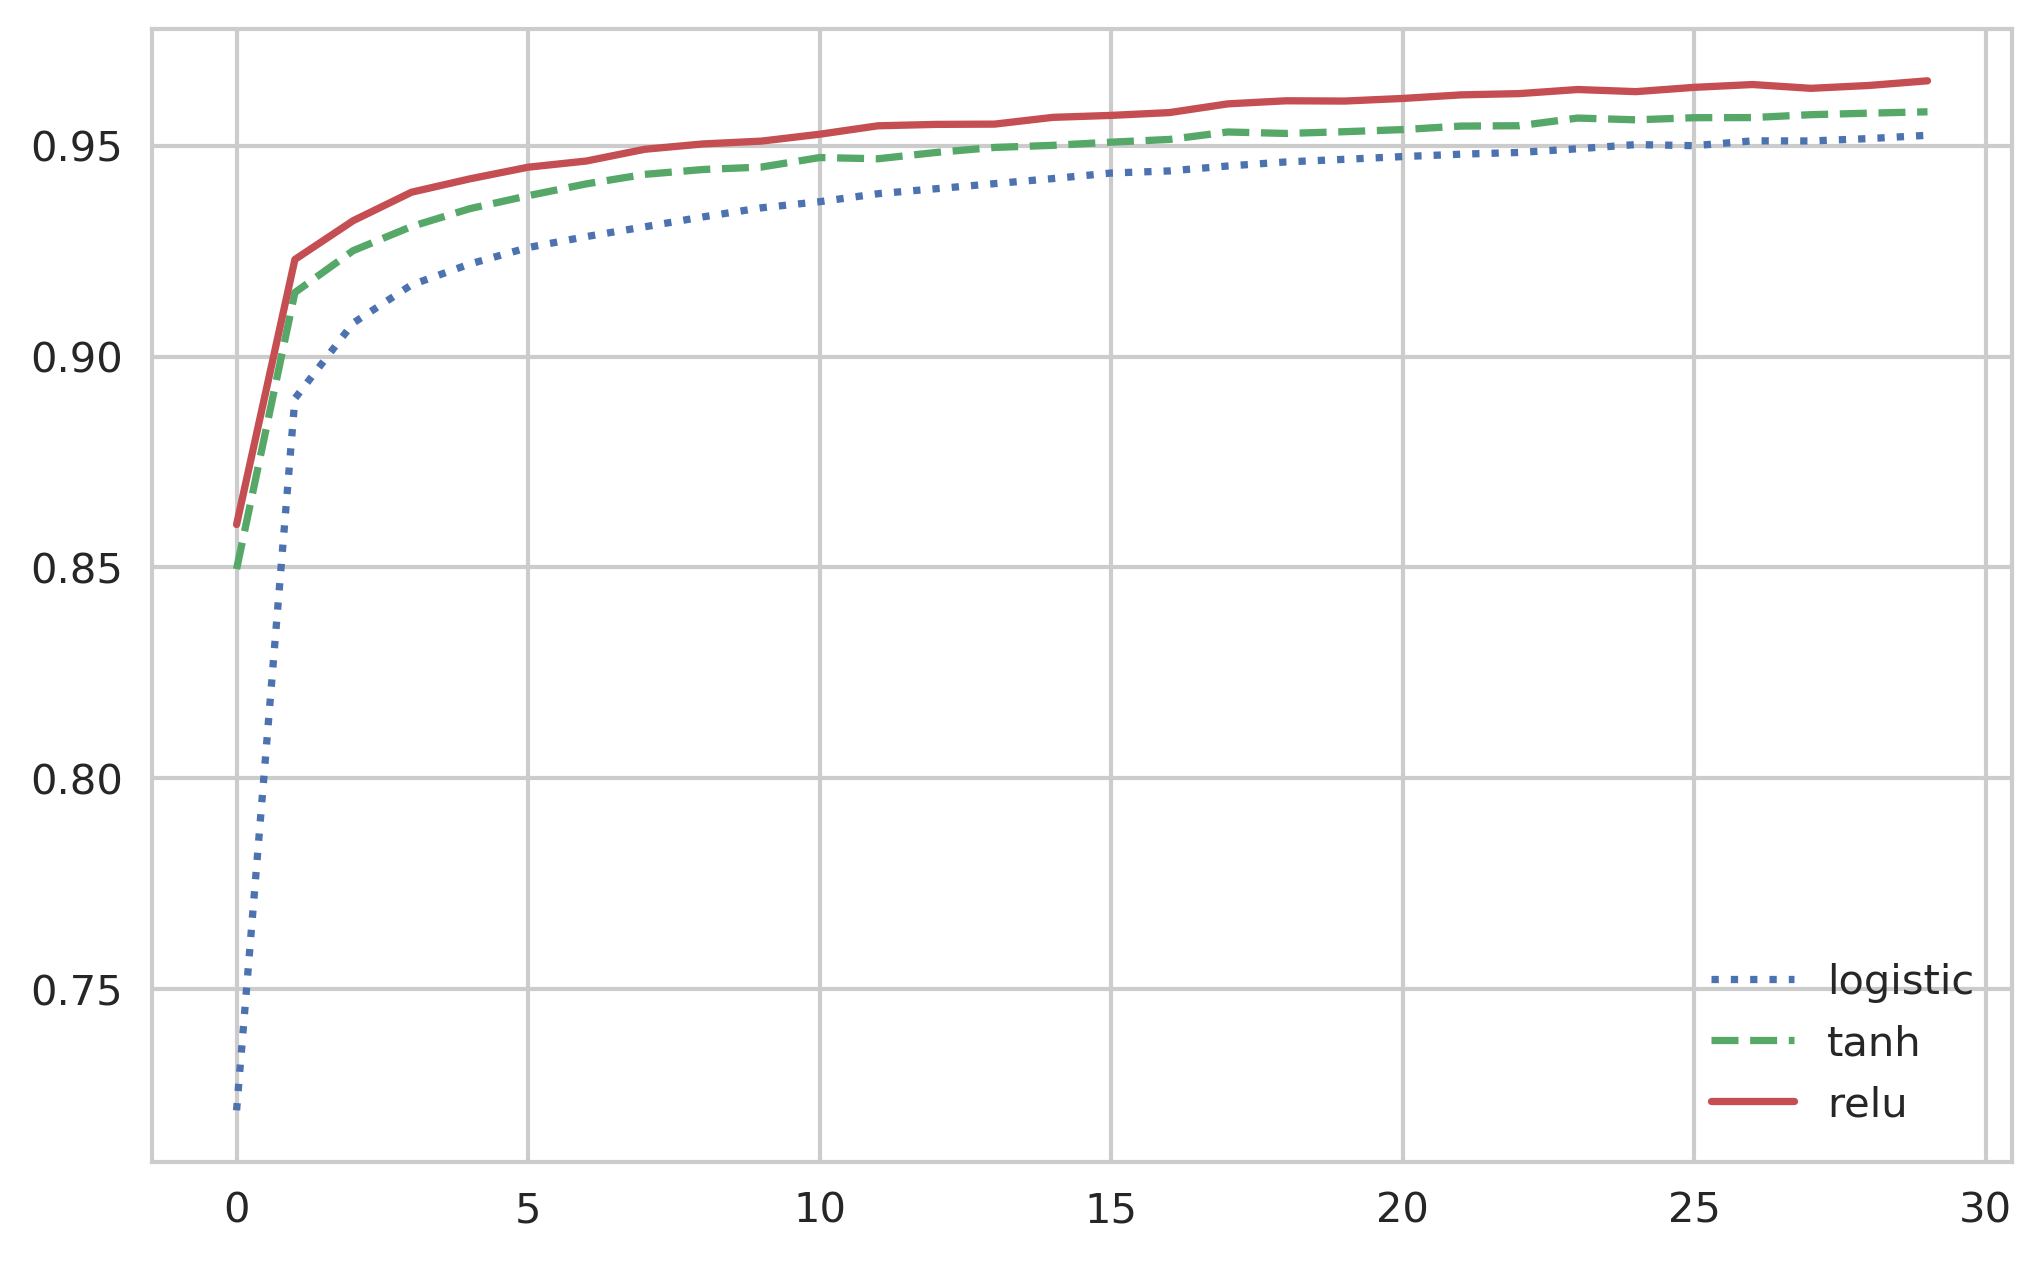

In [34]:
plt.plot(hist1.history['acc'], 'b:', label="logistic")
plt.plot(hist2.history['acc'], 'g--', label="tanh")
plt.plot(hist3.history['acc'], 'r-', label="relu")
plt.legend()
plt.show()

## 가중치 초기화 (Weight initialization)

뉴런에 대한 입력의 수 $n_{in}$가 증가하면 가중 총합 $a$값의 표준편차도 증가한다.
 $$ \text{std}(a) \propto \sqrt{n_{in}} $$
 
예를 들어 입력이 1000개, 그 중 절반이 1이면 표준편차는 약 22.4 이 된다.
 $$ \sqrt{500} \approx 22.4 $$

<img src="https://docs.google.com/drawings/d/1PZwr7wS_3gg7bXtp16XaZCbvxj4tMrfcbCf6GJhaX_0/pub?w=608&h=153">


이렇게 표준 편차가 크면 수렴이 느려지기 때문에 입력 수에 따라 초기화 가중치의 표준편차를 감소하는 초기화 값 조정이 필요하다.
2010년 Xavier Glorot는 반복실험을 통해 다음과 같은 폭을 가진 유니폼 분포를 추천하였다.

$$w \sim \text{uniform}(-\text{limit},\text{limit}) $$

$$\text{limit} = \sqrt{\dfrac{6}{(n_{\text{in}} + n_{\text{out}})}}$$

Keras에서는 `kernel_initializer` 인수로 가중치 초기화 방법을 바꿀 수 있다. 가능한 인수는 다음과 같은 것들이 있다.

* `random_uniform`
* `random_normal`
* `glorot_uniform`
* `glorot_normal`
* `lecun_uniform`
* `lecun_normal`


In [115]:
np.random.seed(0)
model4 = Sequential()
model4.add(Dense(100, kernel_initializer="normal", activation="sigmoid", input_dim=784))
model4.add(Dense(10, kernel_initializer="normal", activation="sigmoid"))
model4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [116]:
%%time
hist4 = model4.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 27s, sys: 30.4 s, total: 5min 57s
Wall time: 2min 44s


In [117]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.add(Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [118]:
%%time
hist5 = model5.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 28s, sys: 30.1 s, total: 5min 58s
Wall time: 2min 45s


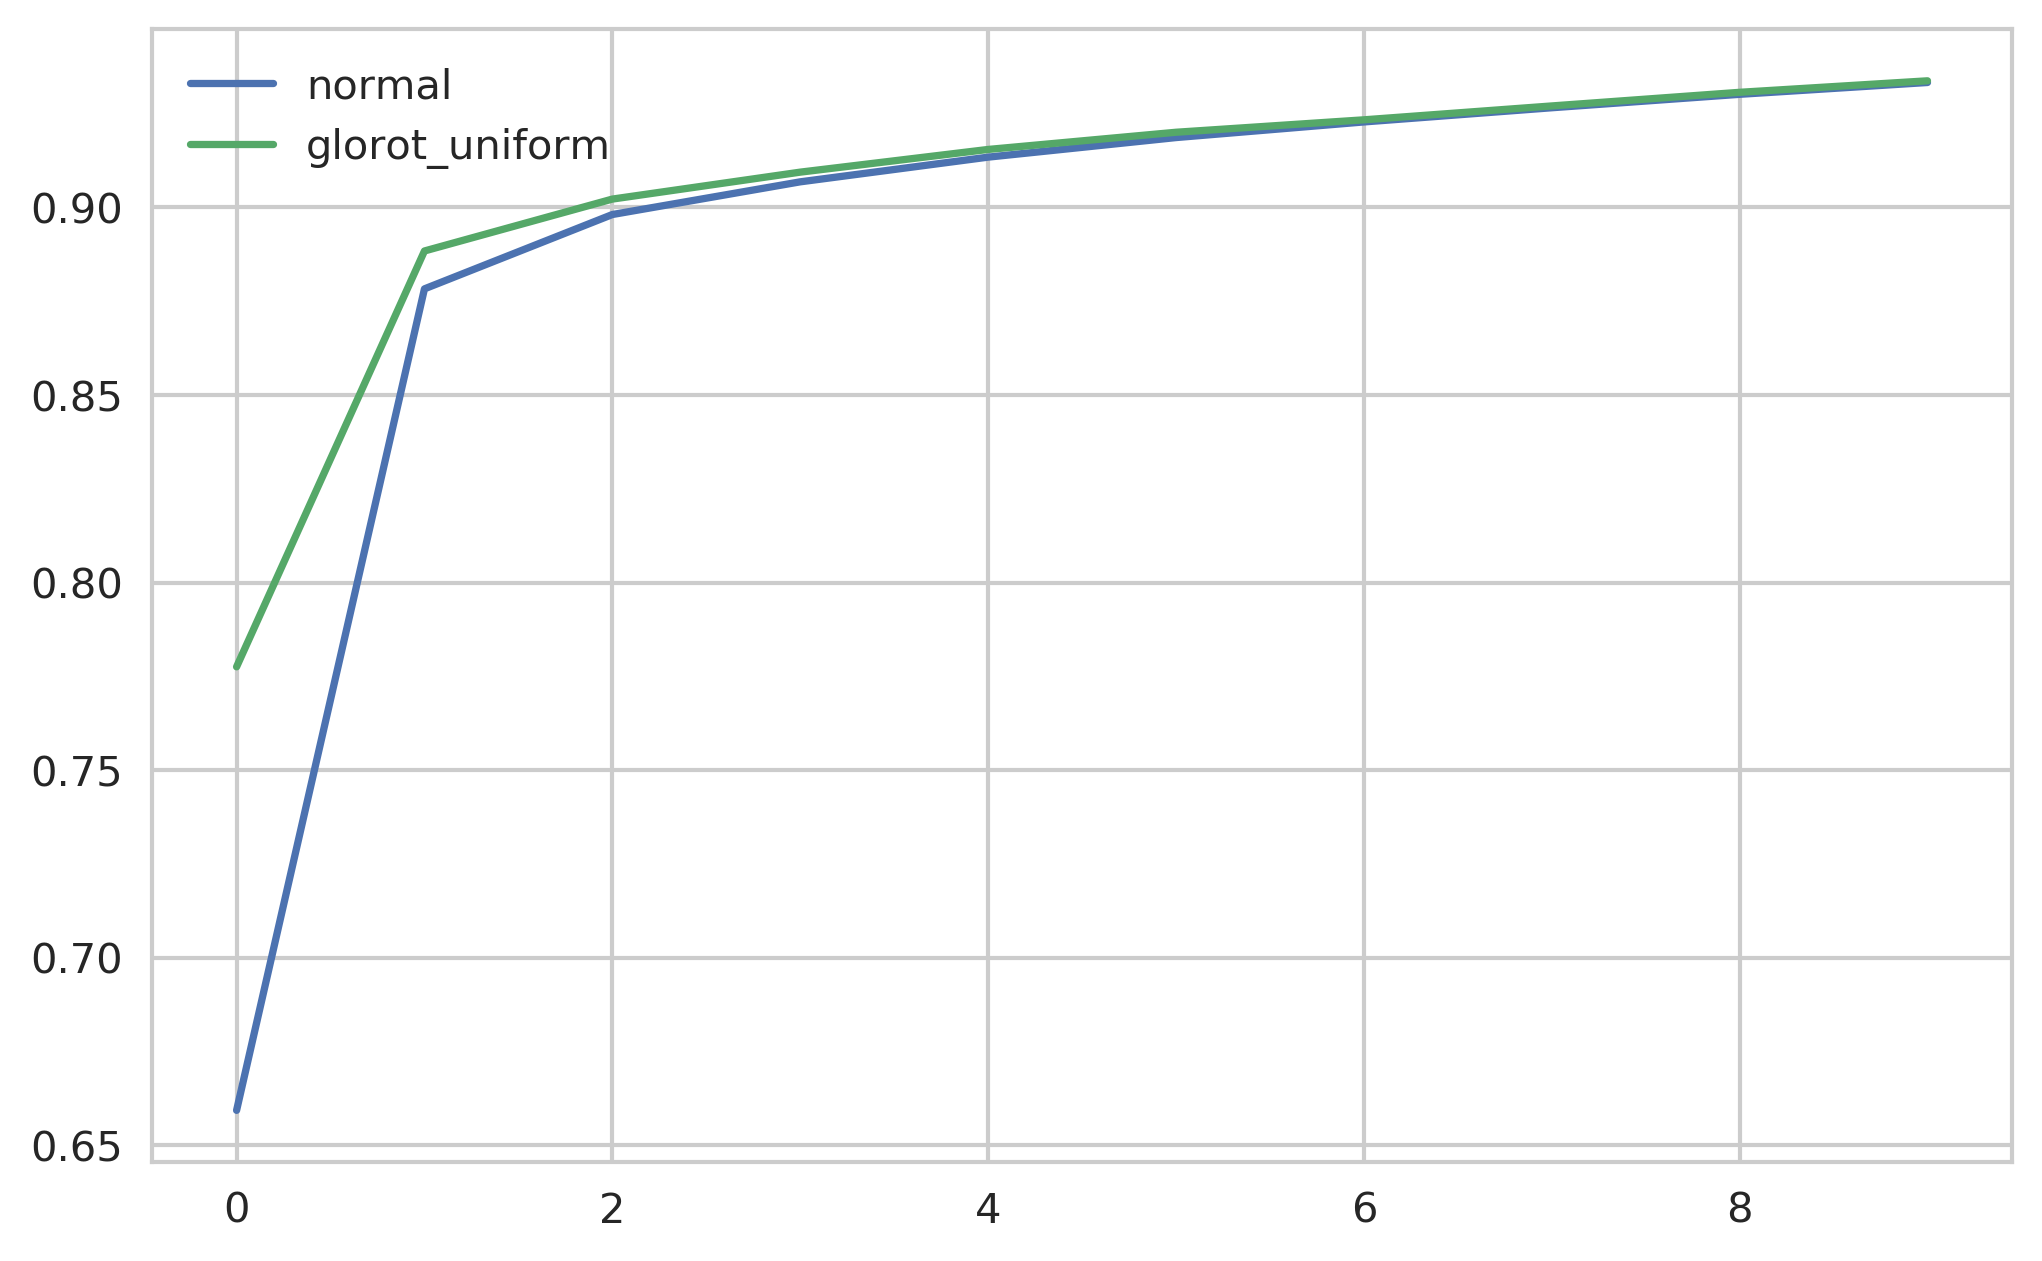

In [119]:
plt.plot(hist4.history['acc'], label="normal")
plt.plot(hist5.history['acc'], label="glorot_uniform")
plt.legend()
plt.show()

## 과최적화 문제

신경망 모형은 파라미터의 수가 다른 모형에 비해 많다. 이렇게 파라미터의 수가 많으면 과최적화 발생 가능성이 증가한다. 즉, 정확도가 나아지지 않거나 나빠져도 오차 함수는 계속 감소하는 현상이 발생한다.

In [120]:
np.random.seed(0)
model6 = Sequential()
model6.add(Dense(30, input_dim=784, activation="sigmoid"))
model6.add(Dense(10, activation="sigmoid"))
model6.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [121]:
%%time
hist6 = model6.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 17min 32s, sys: 1min 32s, total: 19min 5s
Wall time: 8min 49s


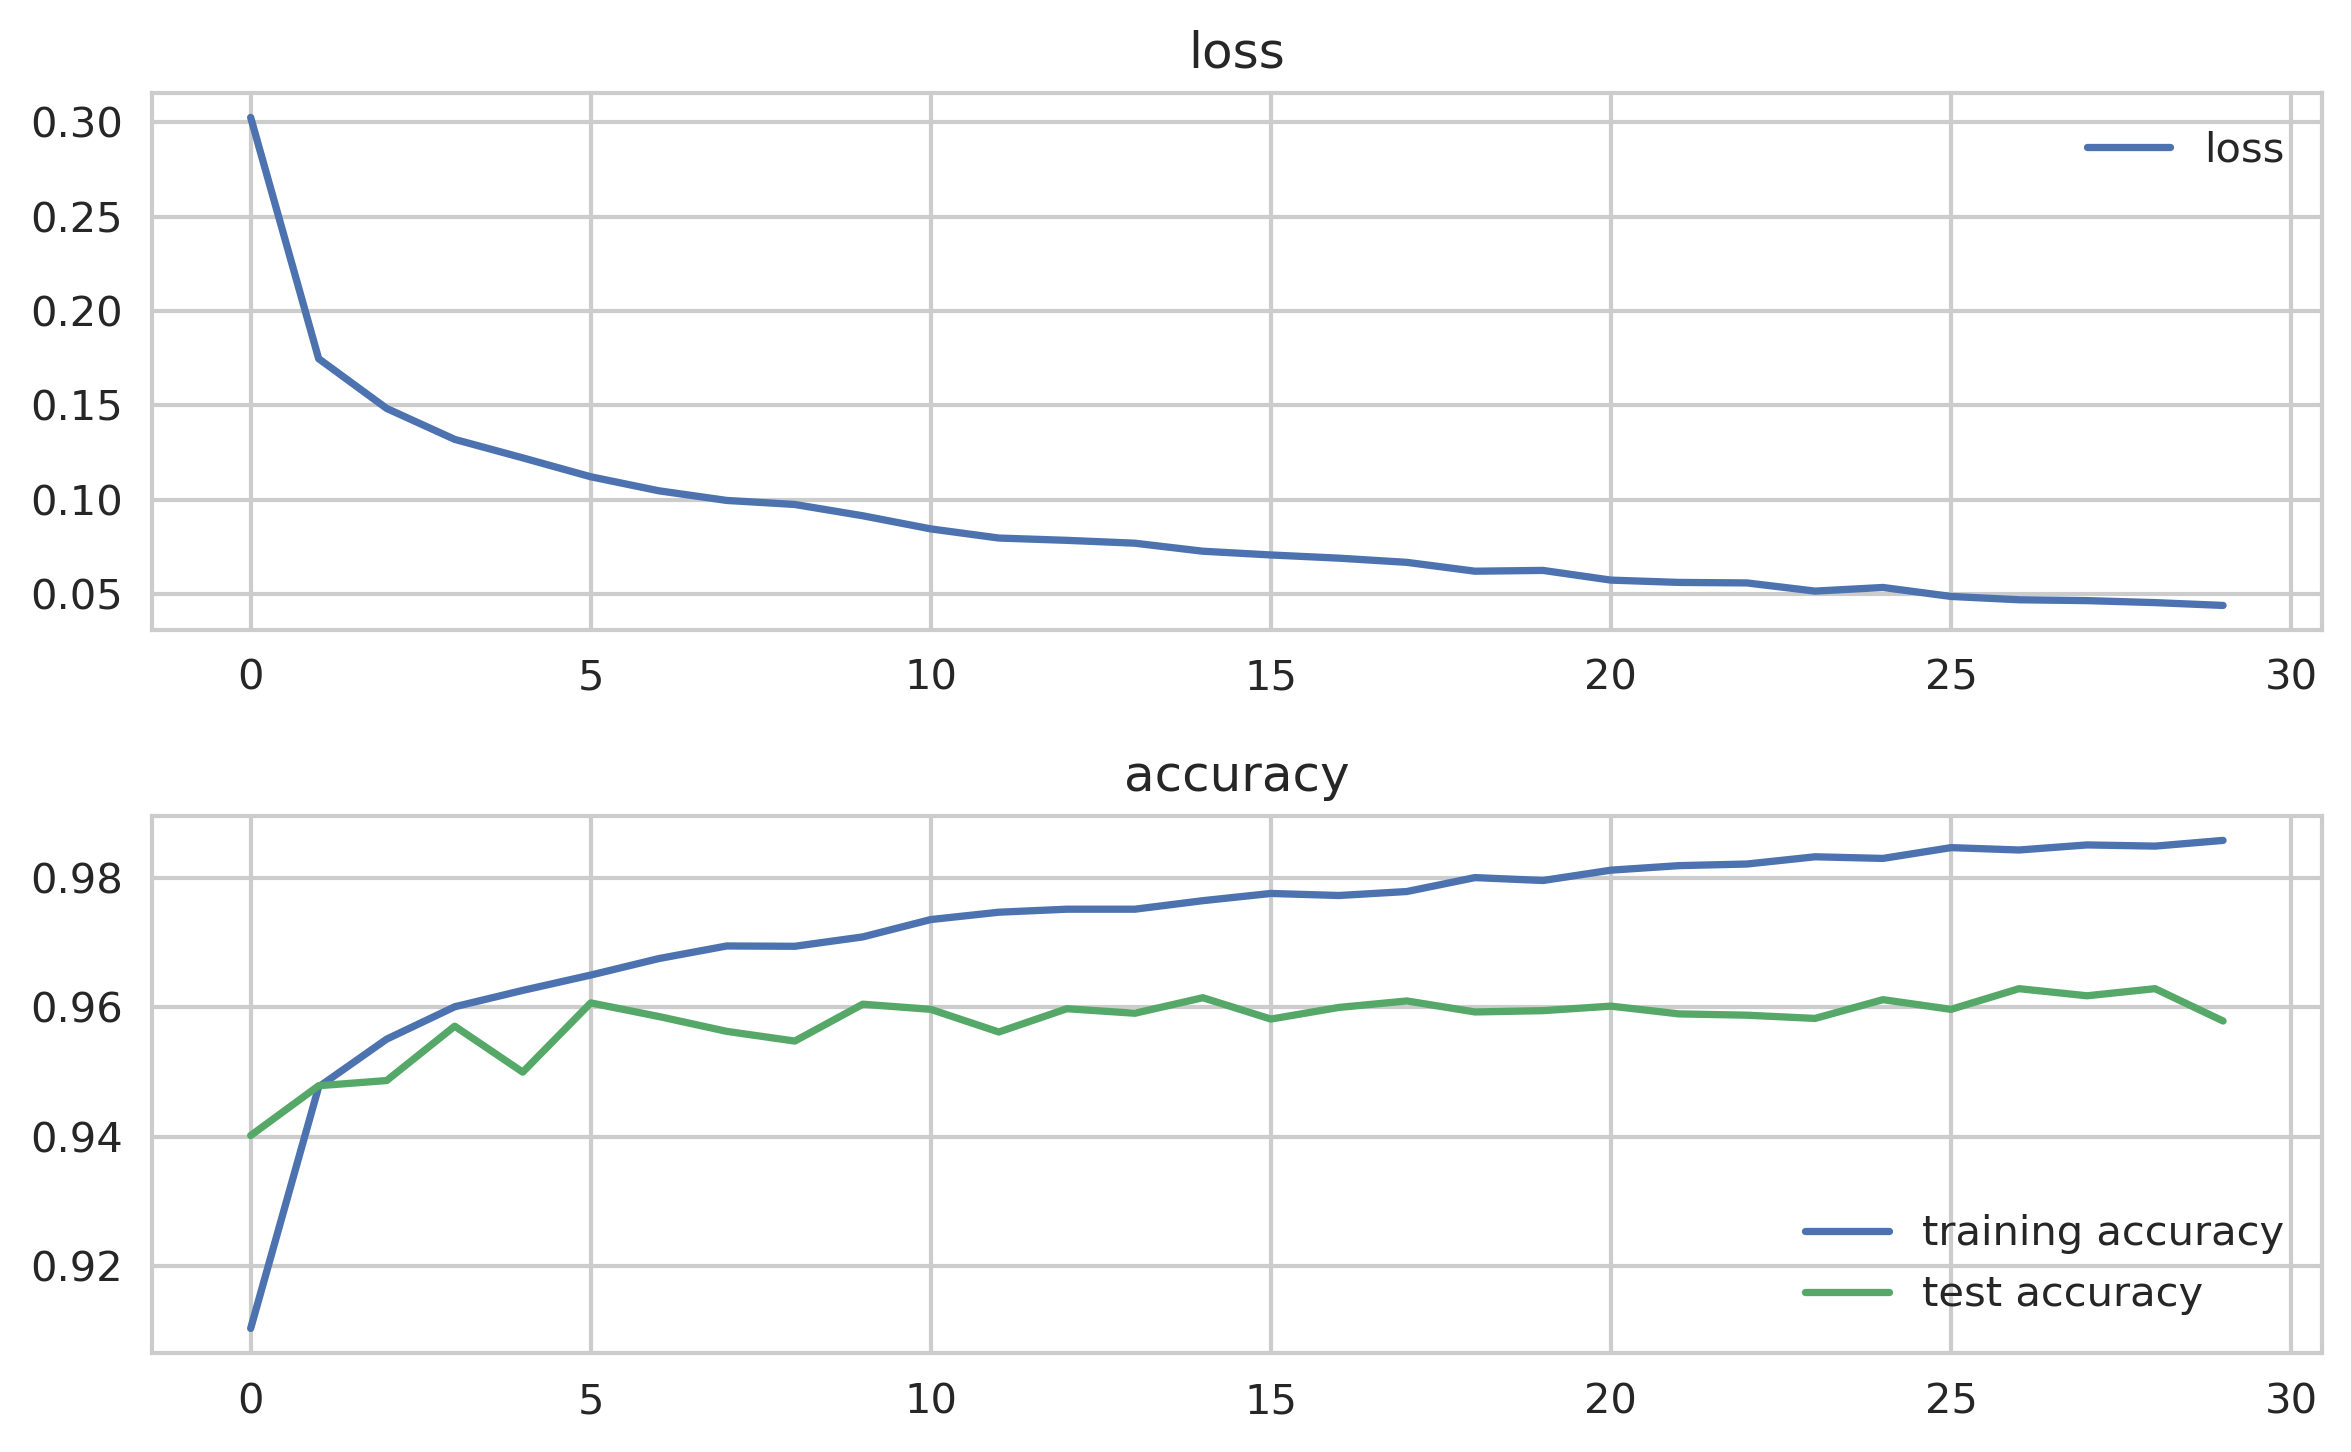

In [122]:
plt.subplot(211)
plt.plot(hist6.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist6.history['acc'], label="training accuracy")
plt.plot(hist6.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## L1, L2 정규화

L1 정규화는 오차 함수에 가중치 행렬의 L1 놈을 추가하는 방법이다.

$$
C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i |w_i|
$$

L2 정규화는 오차 함수에 가중치 행렬의 L2 놈을 추가한다.

$$
C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i w_i^2
$$


Keras에서는 레이어 생성시에 `kernel_regularizer` 인수로 `regularizers` 서브패키지의 `l1`, `l2` regularizer 객체를 넣어서 L1, L2 정규화를 구현한다.

In [14]:
from keras import regularizers

np.random.seed(0)
model7 = Sequential()
model7.add(Dense(30, input_dim=784, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model7.add(Dense(10, activation="sigmoid"))
model7.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
%%time
hist7 = model7.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 18min 24s, sys: 1min 47s, total: 20min 11s
Wall time: 8min 58s


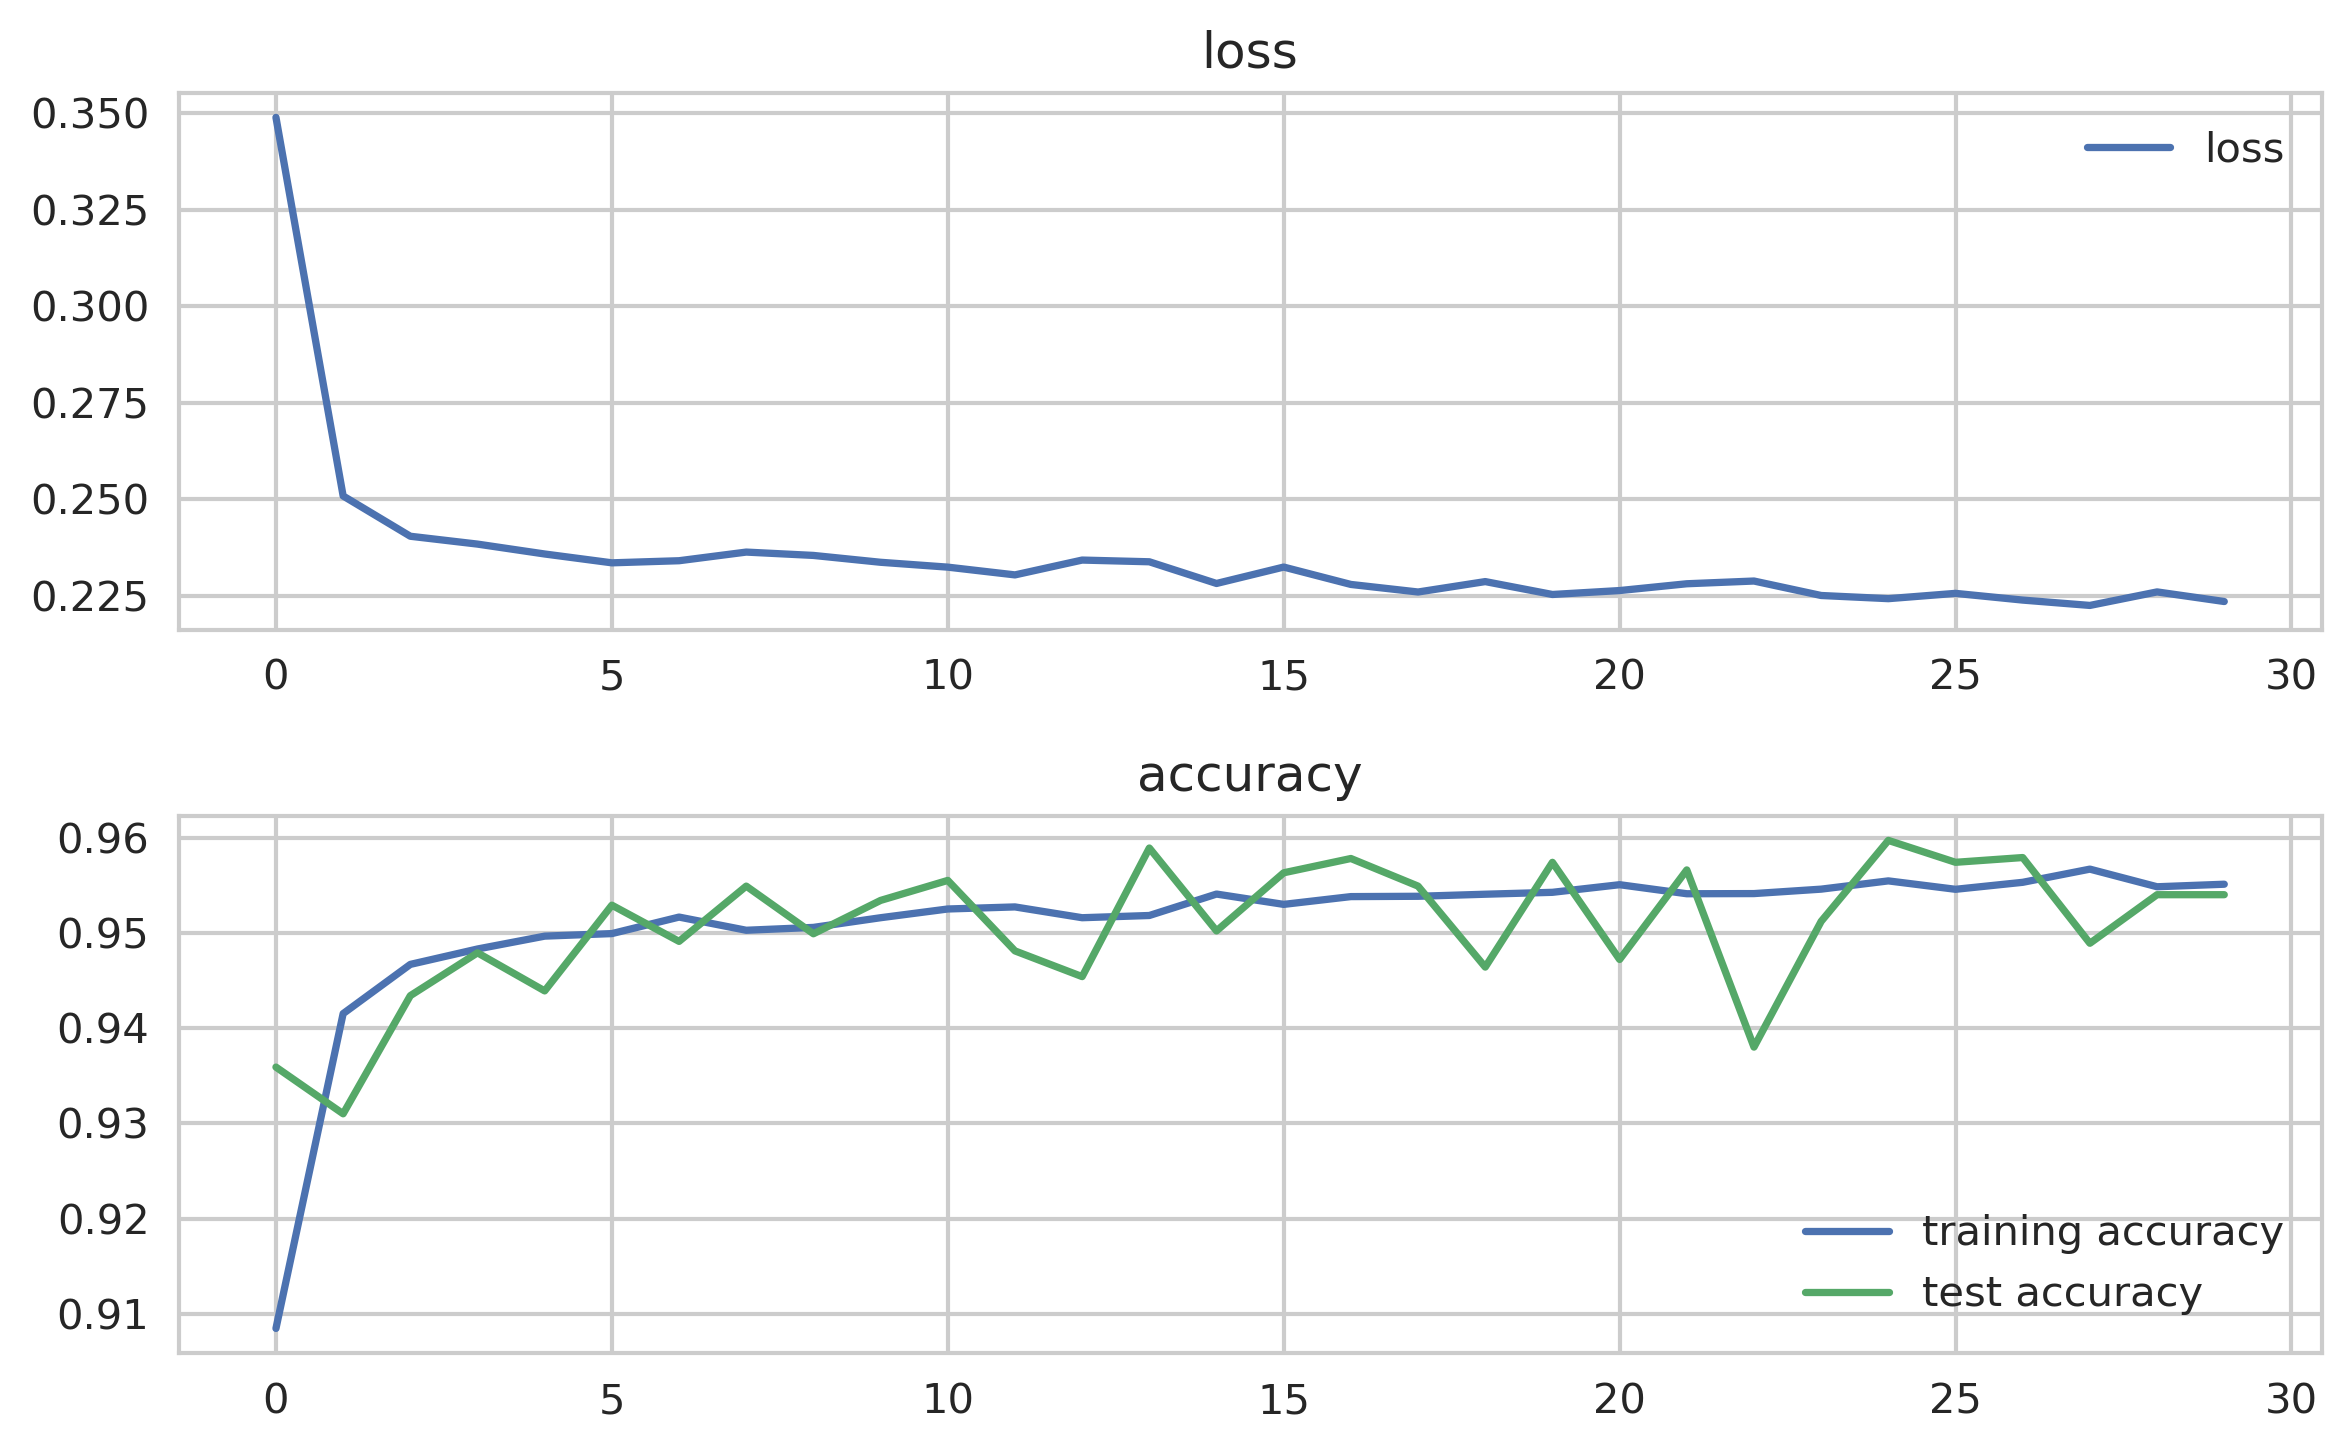

In [16]:
plt.subplot(211)
plt.plot(hist7.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist7.history['acc'], label="training accuracy")
plt.plot(hist7.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## Dropout 정규화

Dropout 정규화 방법은 이러한 문제를 해결하기 위해 epoch 마다 임의의 hidden layer neurons $100p$%(보통 절반)를 dropout 하여 최적화 과정에 포함하지 않는 방법이다. 이 방법을 사용하면 가중치 값들이 특정한 뉴런에만 집중되는 것을 방지하여 정규화 효과를 가져다 준다.

<img src="http://neuralnetworksanddeeplearning.com/images/tikz31.png">

가중치 갱신이 끝나고 테스트 시점에는 가중치에 $p$를 곱하여 스케일링한다.

<img src="https://datascienceschool.net/upfiles/8e5177d1e7dd46a69d5b316ee8748e00.png">

Keras에서 dropout 정규화는 레이어 뒤에 `Dropout` 객체를 추가하여 구현한다.

In [17]:
from keras.layers import Dropout

np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=784, activation="sigmoid"))
model8.add(Dropout(0.1))
model8.add(Dense(10, activation="sigmoid"))
model8.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [18]:
%%time
hist8 = model8.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 17min 54s, sys: 1min 31s, total: 19min 25s
Wall time: 9min 3s


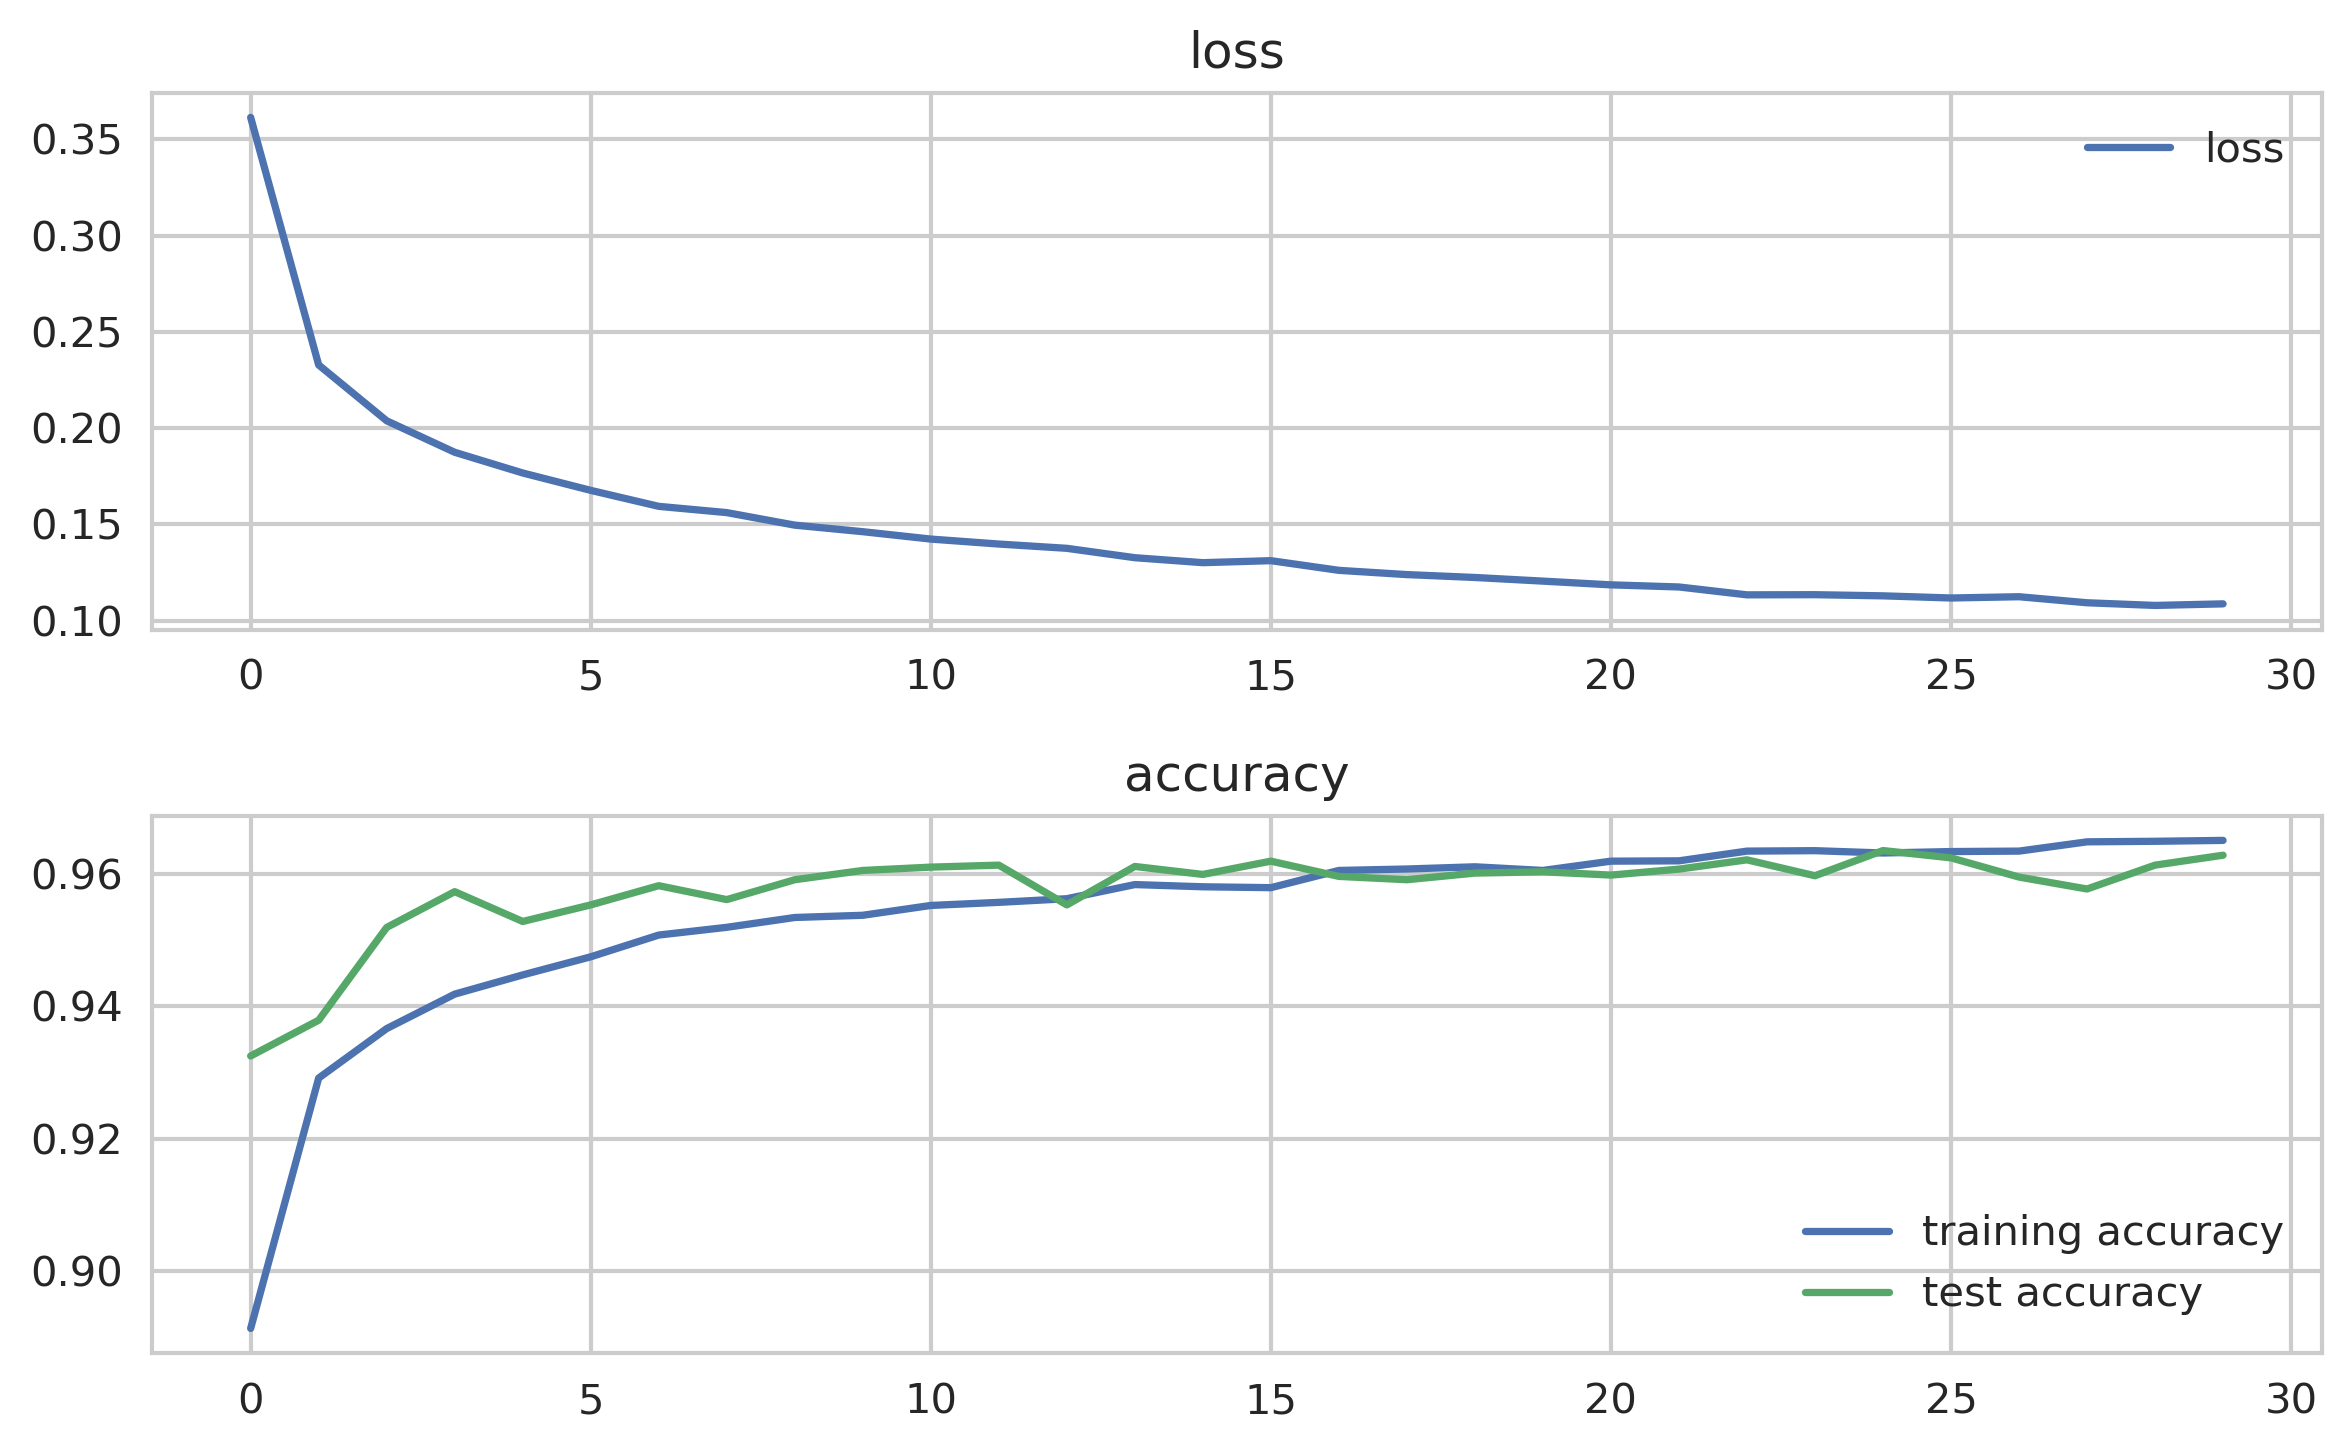

In [19]:
plt.subplot(211)
plt.plot(hist8.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist8.history['acc'], label="training accuracy")
plt.plot(hist8.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## 소프트맥스 출력 

소프트맥스(softmax) 함수는 입력과 출력이 다변수(multiple variable) 인 함수이다. 최고 출력의 위치를 변화하지 않으면서 츨력의 합이 1이 되도록 조정하기 때문에 출력에 확률론적 의미를 부여할 수 있다. 보통 신경망의 최종 출력단에 적용한다.



$$
\begin{eqnarray} 
  y^L_j = \frac{e^{a^L_j}}{\sum_k e^{a^L_k}},
\end{eqnarray}
$$



$$
\begin{eqnarray}
  \sum_j y^L_j & = & \frac{\sum_j e^{a^L_j}}{\sum_k e^{a^L_k}} = 1
\end{eqnarray}
$$



<img src="https://www.tensorflow.org/versions/master/images/softmax-regression-scalargraph.png" style="width:60%;">


In [20]:
from ipywidgets import interactive
from IPython.display import Audio, display

def softmax_plot(z1=0, z2=0, z3=0, z4=0):
    exps = np.array([np.exp(z1), np.exp(z2), np.exp(z3), np.exp(z4)])
    exp_sum = exps.sum()
    plt.bar(range(len(exps)), exps/exp_sum, align="center")
    plt.ylim(0, 1)
    plt.xticks([])
    
v = interactive(softmax_plot, z1=(-3, 5, 0.01), z2=(-3, 5, 0.01), z3=(-3, 5, 0.01), z4=(-3, 5, 0.01))
display(v)

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-3.0, step=0.01), FloatSlider(value=0.0, description='z2', max=5.0, min=-3.0, step=0.01), FloatSlider(value=0.0, description='z3', max=5.0, min=-3.0, step=0.01), FloatSlider(value=0.0, description='z4', max=5.0, min=-3.0, step=0.01), Output()), _dom_classes=('widget-interact',))

Keras에서 출력단의 softmax 활성화 함수는 `activation` 인수의 값을 `softmax`로 지정하여 구현한다.

In [21]:
np.random.seed(0)
model9 = Sequential()
model9.add(Dense(15, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model9.add(Dense(10, activation="softmax", kernel_initializer="glorot_uniform"))
model9.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [22]:
%%time
hist9 = model9.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 28s, sys: 29.4 s, total: 5min 57s
Wall time: 2min 42s


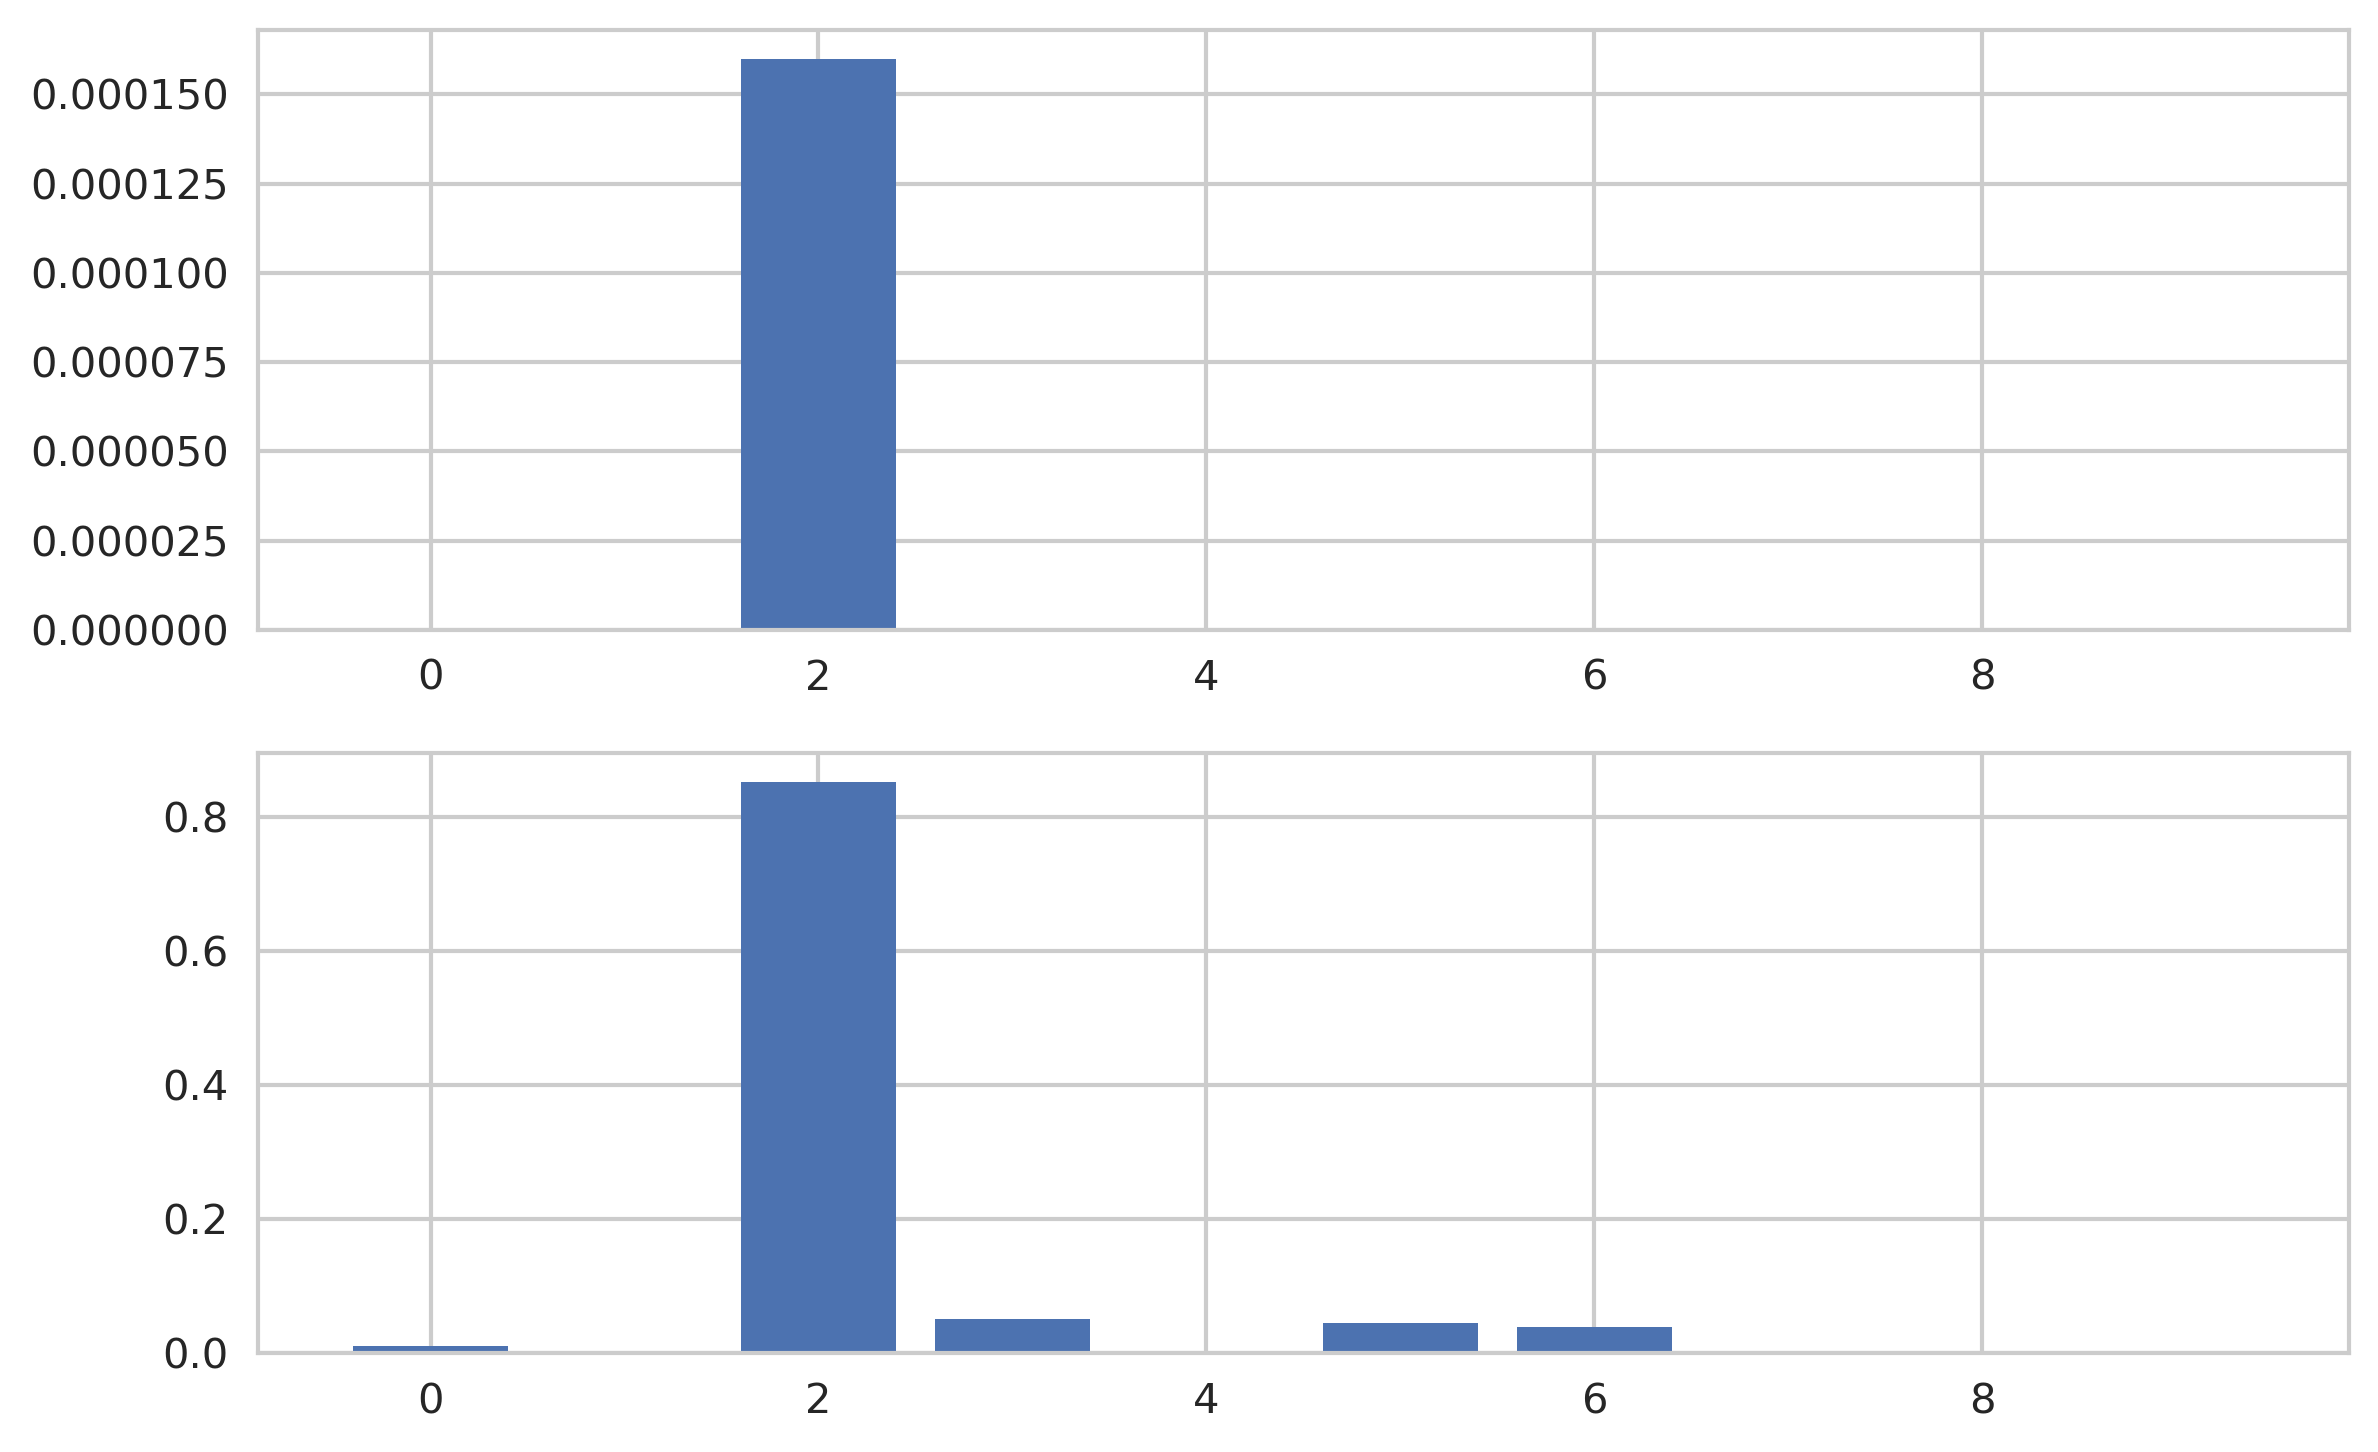

In [23]:
k = 1
y8 = model8.predict(X_test[k:k+1, :])[0]
y9 = model9.predict(X_test[k:k+1, :])[0]

plt.subplot(211)
plt.bar(range(len(y8)), y8, align="center")
plt.subplot(212)
plt.bar(range(len(y9)), y9, align="center")
plt.tight_layout()
plt.show()

## Batch Normalization

Batch Normalization은 mini-batch 만큼의 트레이닝이 끝날 때마다 $a$의 평균과 분산을 계산해서 평균 0, 분산 1이 되도록 스케일링을 해주는 방법이다.

<img src="https://i0.wp.com/mohammadpz.github.io/posts/2015_02_01_IFT6266_Cats_vs_Dogs/img/bn.png?zoom=2">

Keras에서 batch normalization은 레이어 뒤에 `BatchNormalization` 객체를 추가하여 구현한다. 다만 이 경우에는 활성화 함수를 `BatchNormalization` 객체 뒤에 명시적으로 추가해야 한다.

In [19]:
from keras.layers import Activation, BatchNormalization

np.random.seed(0)
model10 = Sequential()
model10.add(Dense(15, input_dim=784))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.add(Dense(10))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [20]:
%%time
hist10 = model10.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 24s, sys: 10.6 s, total: 1min 35s
Wall time: 1min 8s


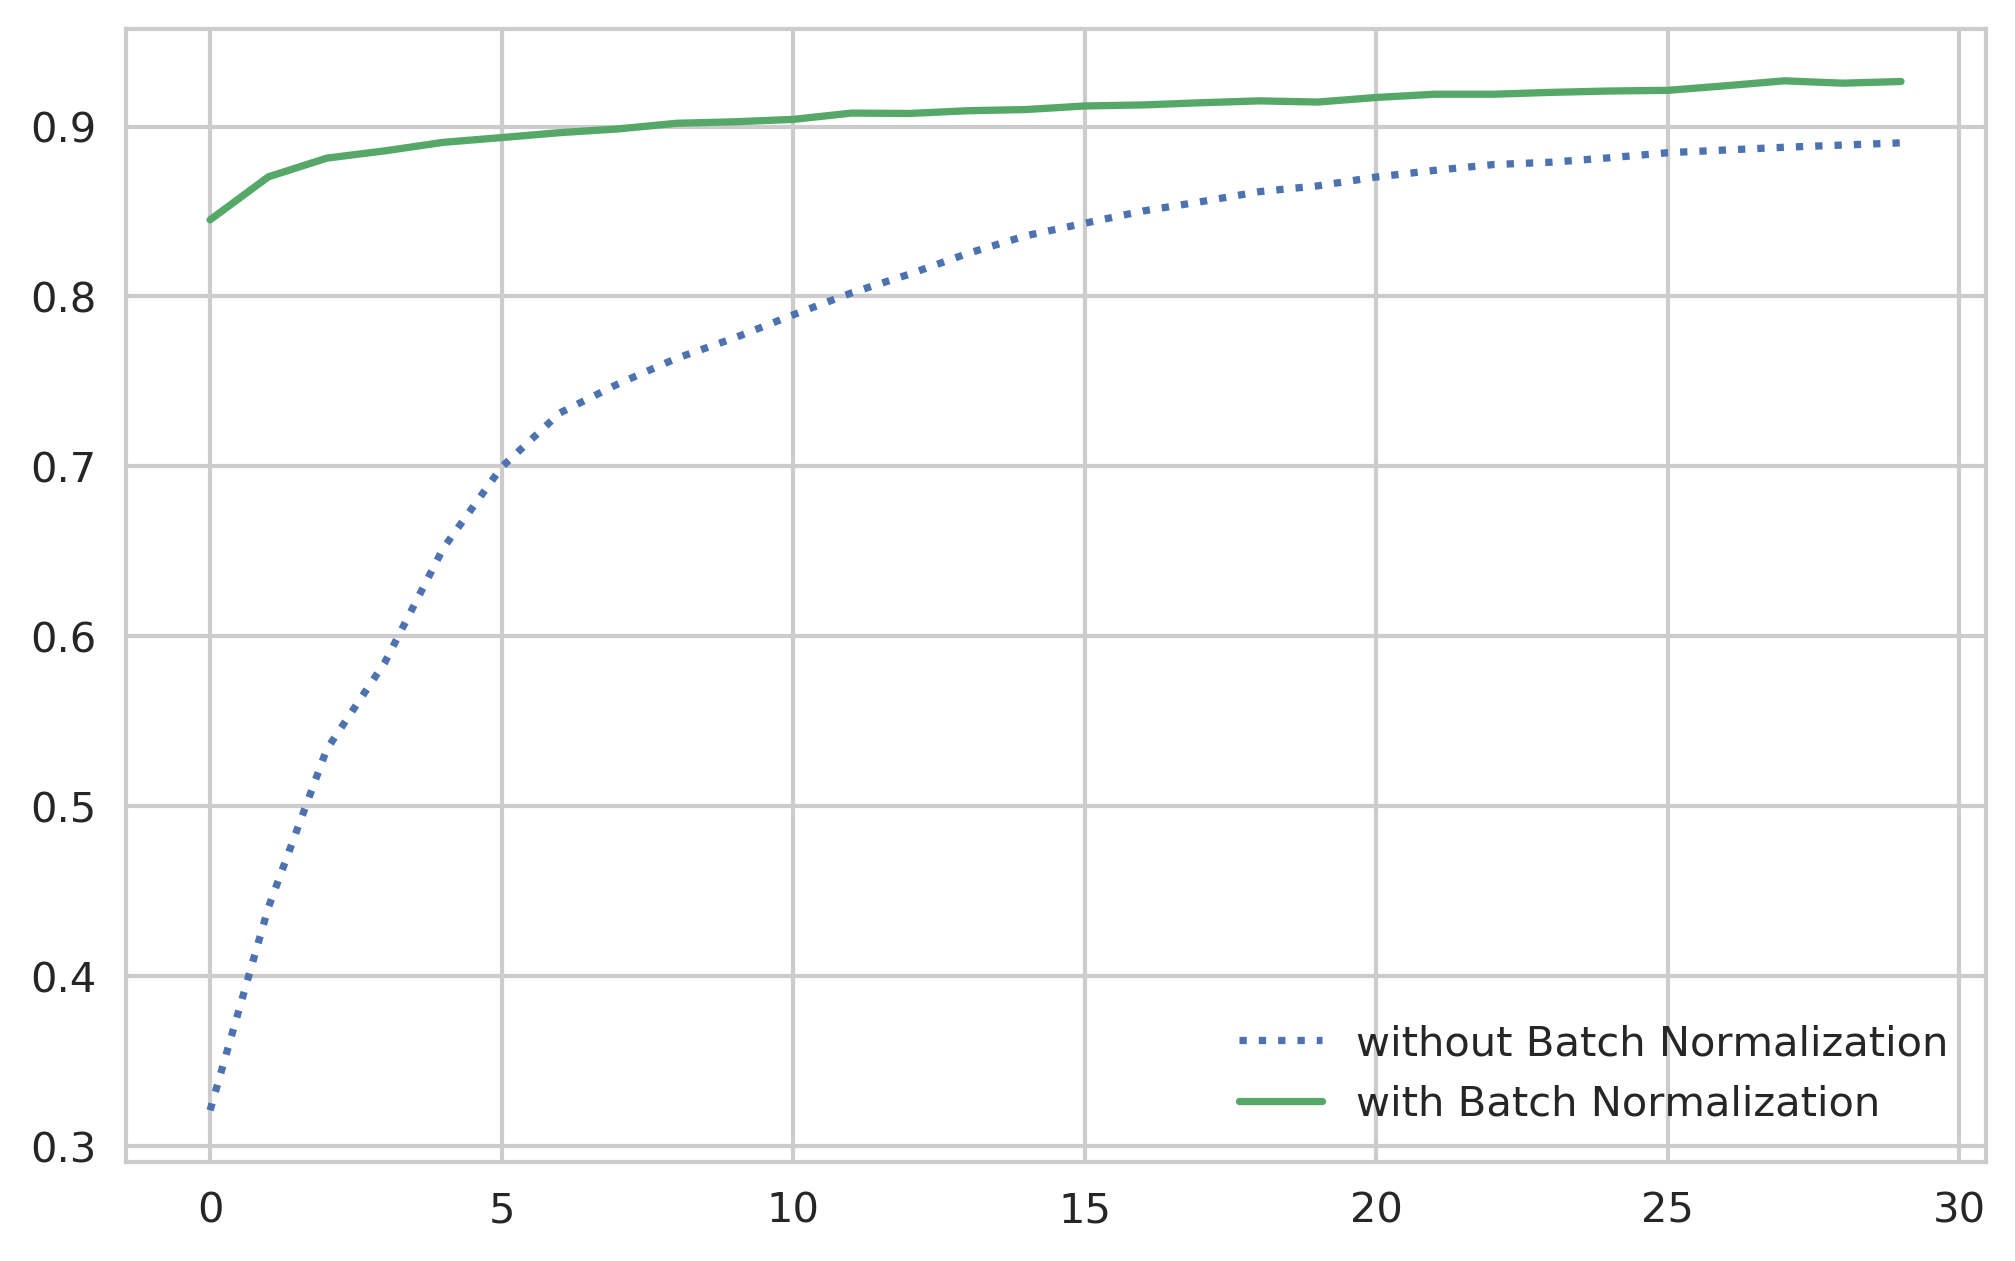

In [21]:
plt.plot(hist0.history['val_acc'], ls=":", label="without Batch Normalization")
plt.plot(hist10.history['val_acc'], label="with Batch Normalization")
plt.legend()
plt.show()